In [222]:
from nba_api.stats.static import players
from nba_api.stats.endpoints import playercareerstats
from nba_api.stats.endpoints import commonplayerinfo
from nba_api.stats.endpoints import playerawards
from nba_api.stats.endpoints import boxscoreadvancedv2
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.endpoints import leagueleaders
from sklearn.preprocessing import StandardScaler
from itertools import product
from bs4 import BeautifulSoup
from lxml import html
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time
import requests
import json
import os

WORKDIR = ''

### Statystyki zawodników

In [223]:
players_stats = pd.read_csv(os.path.join(WORKDIR, 'player_stats.csv'))
seasons = ['1988-89', '1989-90', '1990-91', '1991-92', '1992-93', '1993-94', '1994-95', '1995-96',
           '1996-97', '1997-98', '1998-99', '1999-00', '2000-01', '2001-02', '2002-03', '2003-04',
           '2004-05', '2005-06', '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
           '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18', '2018-19', '2019-20',
           '2020-21', '2021-22', '2022-23']
players_stats.drop(columns=['Unnamed: 0', 'LEAGUE_ID'], inplace=True)
players_stats["GP"] = players_stats["GP"].astype(int)
players_stats = players_stats[players_stats["GP"] > 40]
players_stats = players_stats[players_stats["SEASON_ID"].isin(seasons)]
players_stats.sample(5)

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,REB,AST,STL,BLK,TOV,PF,PTS,DISPLAY_FIRST_LAST,DRAFT_YEAR,DRAFT_NUMBER
10619,201941,2013-14,1610612747,LAL,26.0,72,32.0,1500.0,286,521,...,535.0,54,29.0,64.0,75.0,172,696,Jordan Hill,2009,8
7460,273,1990-91,1610612737,ATL,26.0,78,2.0,1165.0,174,356,...,179.0,55,33.0,27.0,78.0,151,475,Duane Ferrell,Undrafted,Undrafted
21780,203613,2017-18,1610612753,ORL,28.0,69,50.0,2029.0,354,761,...,239.0,171,58.0,16.0,146.0,175,962,Jonathon Simmons,2012,0
3452,202692,2019-20,1610612744,GSW,28.0,48,18.0,1390.0,244,601,...,226.0,151,50.0,17.0,76.0,107,773,Alec Burks,2011,12
16781,1630,2005-06,1610612760,SEA,30.0,47,1.0,583.0,54,124,...,130.0,27,7.0,15.0,40.0,92,154,Mikki Moore,Undrafted,Undrafted


### Wybrani do all-nba

In [224]:
all_nba_nominations = pd.read_csv(os.path.join(WORKDIR, 'all_nba_nominations.csv'))
all_nba_nominations.sample(5)

,Unnamed: 0,2022-23,2021-22,2020-21,2019-20,2018-19,2017-18,2016-17,2015-16,2014-15,...,1997-98,1996-97,1995-96,1994-95,1993-94,1992-93,1991-92,1990-91,1989-90,1988-89
12,12,Domantas Sabonis,Karl-Anthony Towns,Rudy Gobert,Rudy Gobert,Rudy Gobert,Karl-Anthony Towns,DeAndre Jordan,Andre Drummond,DeAndre Jordan,...,Dikembe Mutombo,Shaquille O’Neal,Shaquille O’Neal,Hakeem Olajuwon,Shaquille O’Neal,David Robinson,Brad Daugherty,Hakeem Olajuwon,David Robinson,Robert Parish
6,6,Jaylen Brown,Kevin Durant,LeBron James,Pascal Siakam,Kawhi Leonard,Giannis Antetokounmpo,Kevin Durant,Draymond Green,DeMarcus Cousins,...,Vin Baker,Glen Rice,Shawn Kemp,Shawn Kemp,Shawn Kemp,Dominique Wilkins,Scottie Pippen,Dominique Wilkins,Tom Chambers,Tom Chambers
4,4,Luka Doncic,Luka Doncic,Luka Doncic,Luka Doncic,Stephen Curry,Damian Lillard,Russell Westbrook,Russell Westbrook,James Harden,...,Gary Payton,Tim Hardaway,Anfernee Hardaway,Anfernee Hardaway,Latrell Sprewell,Mark Price,Clyde Drexler,Magic Johnson,Magic Johnson,Magic Johnson
13,13,De’Aaron Fox,Chris Paul,Bradley Beal,Ben Simmons,Russell Westbrook,Stephen Curry,John Wall,Klay Thompson,Klay Thompson,...,Reggie Miller,Anfernee Hardaway,Reggie Miller,Reggie Miller,Gary Payton,Tim Hardaway,Kevin Johnson,Joe Dumars,Joe Dumars,Dale Ellis
14,14,Damian Lillard,Trae Young,Kyrie Irving,Russell Westbrook,Kemba Walker,Victor Oladipo,DeMar DeRozan,Kyle Lowry,Kyrie Irving,...,Mitch Richmond,John Stockton,Mitch Richmond,Clyde Drexler,Mark Price,Drazen Petrovic,Mark Price,John Stockton,Clyde Drexler,Mark Price


### Łączenie statystyk z danymi o nagrodach w jeden dataframe

In [225]:
players_stats["ALL_NBA_NOMINATION"] = [0 for i in range(len(players_stats))]
players_stats.sample(5)

,PLAYER_ID,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,...,AST,STL,BLK,TOV,PF,PTS,DISPLAY_FIRST_LAST,DRAFT_YEAR,DRAFT_NUMBER,ALL_NBA_NOMINATION
13462,1628436,2018-19,1610612752,NYK,23.0,46,18.0,784.0,107,283,...,54,27.0,42.0,25.0,41,322,Luke Kornet,Undrafted,Undrafted,0
646,76050,1990-91,1610612753,ORL,24.0,67,1.0,877.0,144,263,...,25,27.0,7.0,32.0,125,379,Michael Ansley,1989,37,0
15010,950,1999-00,1610612751,NJN,23.0,74,74.0,2881.0,569,1317,...,622,112.0,15.0,270.0,195,1640,Stephon Marbury,1996,4,0
2788,201147,2009-10,1610612750,MIN,24.0,82,82.0,2482.0,409,949,...,193,117.0,29.0,164.0,224,1066,Corey Brewer,2007,7,0
26032,200749,2011-12,1610612751,NJN,28.0,58,35.0,1276.0,96,201,...,35,47.0,39.0,66.0,149,268,Shelden Williams,2006,5,0


In [226]:
for season in all_nba_nominations.columns[1:]:
    for player in all_nba_nominations[season]:
        con1 = players_stats["SEASON_ID"] == season
        con2 = players_stats["DISPLAY_FIRST_LAST"] == player
        players_stats.loc[con1 & con2, 'ALL_NBA_NOMINATION'] = 1
        
players_stats['ALL_NBA_NOMINATION'].value_counts()

ALL_NBA_NOMINATION
0    10073
1      499
Name: count, dtype: int64

In [227]:
not_rookies = list(players_stats['DISPLAY_FIRST_LAST'].unique())
not_rookies

['Alaa Abdelnaby',
 'Kareem Abdul-Jabbar',
 'Mahmoud Abdul-Rauf',
 'Tariq Abdul-Wahad',
 'Shareef Abdur-Rahim',
 'Alex Abrines',
 'Precious Achiuwa',
 'Mark Acres',
 'Quincy Acy',
 'Hassan Adams',
 'Michael Adams',
 'Steven Adams',
 'Rafael Addison',
 'Bam Adebayo',
 'Jeff Adrien',
 'Arron Afflalo',
 'Ochai Agbaji',
 'Mark Aguirre',
 'Danny Ainge',
 'Alexis Ajinca',
 'Mark Alarie',
 'Santi Aldama',
 'Furkan Aldemir',
 'Cole Aldrich',
 'LaMarcus Aldridge',
 'Cory Alexander',
 'Courtney Alexander',
 'Joe Alexander',
 'Victor Alexander',
 'Nickeil Alexander-Walker',
 'Steve Alford',
 'Grayson Allen',
 'Jarrett Allen',
 'Jerome Allen',
 'Lavoy Allen',
 'Malik Allen',
 'Randy Allen',
 'Ray Allen',
 'Tony Allen',
 'Derrick Alston',
 'Rafer Alston',
 'Jose Alvarado',
 'John Amaechi',
 'Ashraf Amaya',
 'Al-Farouq Aminu',
 'Lou Amundson',
 'Chris Andersen',
 'David Andersen',
 'Alan Anderson',
 'Derek Anderson',
 'Greg Anderson',
 'James Anderson',
 'Justin Anderson',
 'Kenny Anderson',
 'Kyle 

# Eksploracyjna analiza danych

In [228]:
players_stats.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10572 entries, 0 to 26680
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PLAYER_ID           10572 non-null  int64  
 1   SEASON_ID           10572 non-null  object 
 2   TEAM_ID             10572 non-null  int64  
 3   TEAM_ABBREVIATION   10572 non-null  object 
 4   PLAYER_AGE          10572 non-null  float64
 5   GP                  10572 non-null  int64  
 6   GS                  10572 non-null  float64
 7   MIN                 10572 non-null  float64
 8   FGM                 10572 non-null  int64  
 9   FGA                 10572 non-null  int64  
 10  FG_PCT              10572 non-null  float64
 11  FG3M                10572 non-null  float64
 12  FG3A                10572 non-null  float64
 13  FG3_PCT             10572 non-null  float64
 14  FTM                 10572 non-null  int64  
 15  FTA                 10572 non-null  int64  
 16  FT_PCT   

In [229]:
players_stats.describe()

,PLAYER_ID,TEAM_ID,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,...,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PTS,ALL_NBA_NOMINATION
count,1.057200e+04,1.057200e+04,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,...,10572.00000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000,10572.000000
mean,2.300784e+05,1.610613e+09,27.251703,66.501986,35.709327,1667.481271,266.605184,578.478339,0.457869,45.680382,...,81.23392,213.891128,295.125047,158.052592,54.337117,34.557132,98.375426,145.956583,710.473420,0.047200
std,4.900296e+05,8.575098e+00,4.155697,12.649757,29.637110,737.099335,167.879795,351.935455,0.057242,52.640831,...,66.02260,137.811707,194.207967,144.972235,34.890654,38.981786,60.910242,60.365972,457.022912,0.212077
min,2.000000e+00,1.610613e+09,18.000000,41.000000,0.000000,122.000000,6.000000,19.000000,0.189000,0.000000,...,0.00000,8.000000,14.000000,0.000000,1.000000,0.000000,2.000000,9.000000,16.000000,0.000000
25%,7.850000e+02,1.610613e+09,24.000000,56.000000,6.000000,1065.000000,134.000000,299.000000,0.420000,1.000000,...,32.00000,114.000000,153.000000,58.000000,29.000000,10.000000,52.000000,100.000000,350.750000,0.000000
50%,2.440000e+03,1.610613e+09,27.000000,69.000000,31.000000,1635.000000,231.000000,507.000000,0.452000,27.000000,...,61.00000,182.000000,247.000000,111.000000,47.000000,21.000000,84.000000,141.000000,610.000000,0.000000
75%,2.019510e+05,1.610613e+09,30.000000,78.000000,65.000000,2234.000000,366.000000,792.000000,0.489000,75.000000,...,112.00000,277.000000,385.000000,210.000000,72.000000,43.250000,132.000000,187.000000,975.000000,0.000000
max,1.631323e+06,1.610613e+09,43.000000,82.000000,82.000000,3533.000000,1034.000000,2173.000000,0.776000,402.000000,...,523.00000,1007.000000,1530.000000,1164.000000,263.000000,376.000000,464.000000,371.000000,2832.000000,1.000000


### 20 graczy z największą ilością nominacji do all-nba

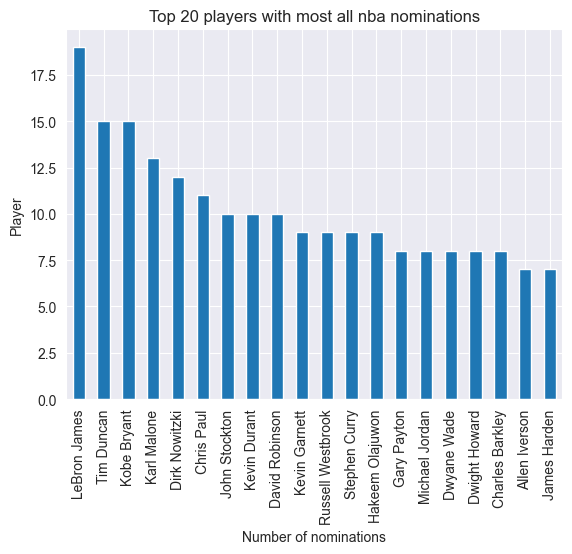

In [230]:
sum_nom = players_stats[players_stats["ALL_NBA_NOMINATION"] == True]["DISPLAY_FIRST_LAST"].value_counts()
sum_nom[:20].plot(kind='bar')
plt.title('Top 20 players with most all nba nominations')
plt.xlabel('Number of nominations')
plt.ylabel('Player')
plt.show()

### Macierz korelacji między poszczególnymi cechami

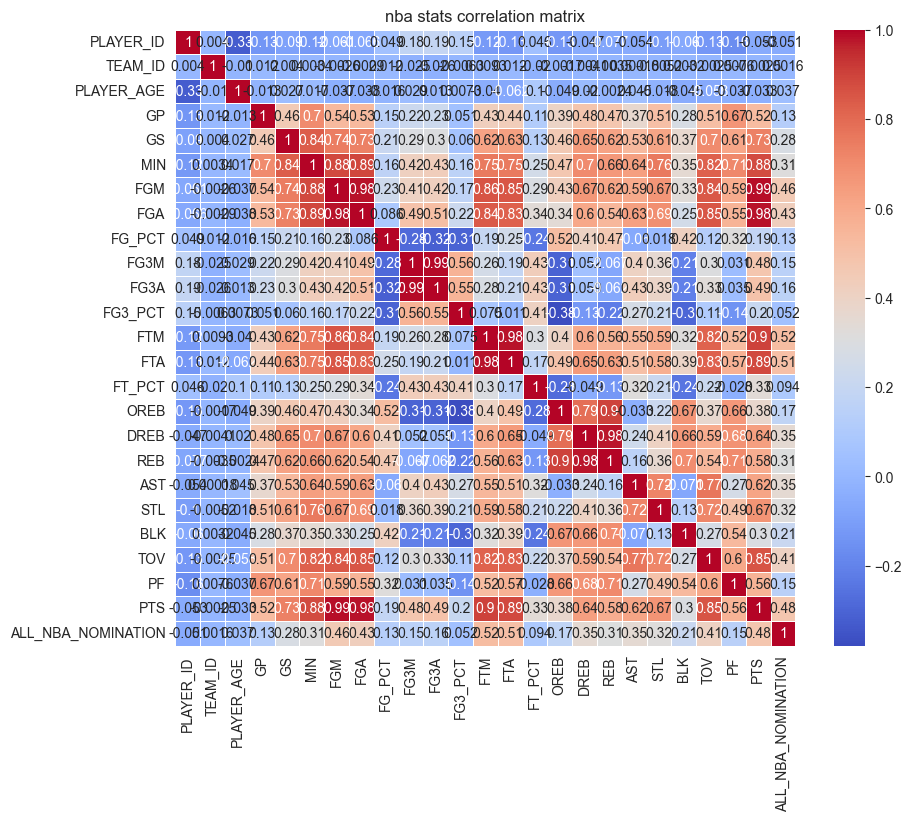

In [231]:
numerical_data = players_stats.select_dtypes(include='number')
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('nba stats correlation matrix')
plt.show()

### Cechy najbardziej skorelowane z nominacją do all-nba

In [232]:
correlation_matrix['ALL_NBA_NOMINATION'].sort_values(ascending=False)[1:]

FTM           0.515692
FTA           0.509911
PTS           0.477331
FGM           0.455666
FGA           0.425283
TOV           0.409774
DREB          0.353218
AST           0.349292
STL           0.319263
MIN           0.311598
REB           0.309707
GS            0.282501
BLK           0.209688
OREB          0.173729
FG3A          0.159844
FG3M          0.153461
PF            0.147871
FG_PCT        0.132770
GP            0.125481
FT_PCT        0.093860
FG3_PCT       0.052271
PLAYER_AGE    0.036967
TEAM_ID       0.001638
PLAYER_ID    -0.050801
Name: ALL_NBA_NOMINATION, dtype: float64

### Średni wiek gracza nominowanego do all-nba w każdym sezonie

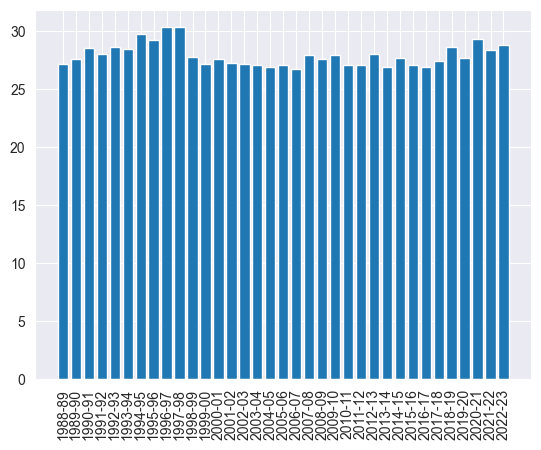

In [233]:
def get_mean_age(df, season):
    con1 = df["SEASON_ID"] == season
    con2 = df["ALL_NBA_NOMINATION"] == 1
    df = df[con1 & con2]['PLAYER_AGE']
    return sum(df) / len(df)
    
mean_ages = [get_mean_age(players_stats, season) for season in seasons]
plt.bar(seasons, mean_ages)
plt.xticks(rotation=90)
plt.show()

### Drużyny z największą ilościa graczy w all-nba

In [234]:
players_stats[players_stats["ALL_NBA_NOMINATION"] == 1]['TEAM_ABBREVIATION'].value_counts()

TEAM_ABBREVIATION
LAL    31
SAS    28
HOU    26
PHX    26
MIA    20
CHI    20
OKC    18
DAL    18
DET    18
CLE    17
GSW    17
POR    16
UTH    16
LAC    16
SEA    15
PHI    14
SAC    14
MIN    14
UTA    14
BOS    14
ORL    13
MIL    12
NYK    11
DEN    10
ATL    10
TOR     9
WAS     8
SAN     8
NJN     7
IND     7
GOS     7
NOH     5
CHH     5
PHL     4
MEM     4
NOP     3
BKN     2
CHA     2
Name: count, dtype: int64

### Drużyny z największą ilością graczy w all-nba w każdym sezonie

In [235]:
def get_team_with_most_nominated(df, season):
    con1 = df["SEASON_ID"] == season
    con2 = df["ALL_NBA_NOMINATION"] == 1
    df = df[con1 & con2]['TEAM_ABBREVIATION']
    return df.value_counts().keys()[0], df.value_counts().iloc[0]

teams = [get_team_with_most_nominated(players_stats, season) for season in seasons]
for season, team in zip(seasons, teams):
    print(season, ': ', team)


1988-89 :  ('PHX', 2)
1989-90 :  ('PHX', 2)
1990-91 :  ('LAL', 2)
1991-92 :  ('CLE', 2)
1992-93 :  ('NJN', 2)
1993-94 :  ('PHX', 2)
1994-95 :  ('SEA', 3)
1995-96 :  ('CHI', 2)
1996-97 :  ('CHI', 2)
1997-98 :  ('SEA', 2)
1998-99 :  ('MIA', 2)
1999-00 :  ('SAS', 2)
2000-01 :  ('SAS', 2)
2001-02 :  ('PHI', 2)
2002-03 :  ('DAL', 2)
2003-04 :  ('MIN', 2)
2004-05 :  ('PHX', 2)
2005-06 :  ('DET', 2)
2006-07 :  ('HOU', 2)
2007-08 :  ('UTA', 2)
2008-09 :  ('DEN', 2)
2009-10 :  ('LAL', 2)
2010-11 :  ('LAL', 2)
2011-12 :  ('NYK', 2)
2012-13 :  ('LAL', 2)
2013-14 :  ('POR', 2)
2014-15 :  ('LAC', 3)
2015-16 :  ('GSW', 3)
2016-17 :  ('GSW', 3)
2017-18 :  ('MIN', 2)
2018-19 :  ('GSW', 2)
2019-20 :  ('LAL', 2)
2020-21 :  ('LAC', 2)
2021-22 :  ('PHX', 2)
2022-23 :  ('BOS', 2)


### 

# Preprocessing

### Dane dla których dokonywane są predykcje


In [236]:
to_predict = pd.read_csv('player-stats-2023-24.csv')
to_predict.sample(3)

,Unnamed: 0,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,...,REB,AST,STL,BLK,TOV,PF,PTS,DISPLAY_FIRST_LAST,DRAFT_YEAR,DRAFT_NUMBER
568,3339,1631114,2023-24,0,1610612760,OKC,23.0,71,71,2224.0,...,282,322,80,45,123,175,1355,Jalen Williams,2022,12
438,2676,1641871,2023-24,0,1610612757,POR,27.0,68,20,1214.0,...,250,67,33,38,52,161,617,Duop Reath,Undrafted,Undrafted
259,1577,1630198,2023-24,0,1610612760,OKC,24.0,78,1,1445.0,...,180,99,46,22,47,87,636,Isaiah Joe,2020,49


###Rozbicie zbioru danych na cechy i zmienną zależną którą bedziemy próbowali przewidzieć (prawdopodobieństwo nominacji zawodnika do drużyny all-nba)

In [237]:
target = players_stats["ALL_NBA_NOMINATION"]
features = players_stats.drop(columns=['ALL_NBA_NOMINATION', 'TEAM_ID', 'SEASON_ID', 'PLAYER_ID', 'DISPLAY_FIRST_LAST'])
features.sample(2)

,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,DRAFT_YEAR,DRAFT_NUMBER
14452,MIL,35.0,78,78.0,2372.0,477,899,0.531,136.0,364.0,...,363.0,520.0,99,37.0,193.0,107.0,203,1239,2008,10
10012,MIA,25.0,80,80.0,2675.0,346,641,0.540,0.0,4.0,...,487.0,726.0,108,63.0,41.0,113.0,260,870,Undrafted,Undrafted


### Następnie znajdujemy kolumny numeryczne i kategoryczne w naszym zbiorze danych

In [238]:
numerical = list(features.select_dtypes(include=['int', 'float']).columns)
numerical

['PLAYER_AGE',
 'GP',
 'GS',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS']

In [239]:
non_numerical = list(features.select_dtypes(include=['object']).columns)
non_numerical

['TEAM_ABBREVIATION', 'DRAFT_YEAR', 'DRAFT_NUMBER']

### Dane kategoryczne - konwersja draft_year, draft_number do int oraz one hot encoding na team_abbreviation

In [240]:
print(features['DRAFT_YEAR'].unique())
features['DRAFT_YEAR'] = features['DRAFT_YEAR'].replace('Undrafted', -1)
features['DRAFT_YEAR'] = features['DRAFT_YEAR'].astype(int)
print(features['DRAFT_YEAR'].unique())

['1990' '1969' '1997' '1996' '2013' '2020' '1985' '2012' '2006' '1986'
 '2017' 'Undrafted' '2007' '2022' '1981' '2008' '2021' '2010' '1995'
 '2000' '1991' '2019' '1987' '2018' '2011' '2004' '1994' '1998' '2002'
 '2015' '2014' '1989' '1982' '1984' '1988' '2003' '2001' '1999' '2009'
 '1983' '1993' '1992' '2005' '2016' '1978' '1980' '1979' '1976' '1977'
 '1973']
[1990 1969 1997 1996 2013 2020 1985 2012 2006 1986 2017   -1 2007 2022
 1981 2008 2021 2010 1995 2000 1991 2019 1987 2018 2011 2004 1994 1998
 2002 2015 2014 1989 1982 1984 1988 2003 2001 1999 2009 1983 1993 1992
 2005 2016 1978 1980 1979 1976 1977 1973]


In [241]:
print(features['DRAFT_NUMBER'].unique())
features['DRAFT_NUMBER'] = features['DRAFT_NUMBER'].replace('Undrafted', -1)
features['DRAFT_NUMBER'] = features['DRAFT_NUMBER'].fillna(-1)
features['DRAFT_NUMBER'] = features['DRAFT_NUMBER'].astype(int)
print(features['DRAFT_NUMBER'].unique())

['25' '1' '3' '11' '32' '20' '40' '37' '54' '66' '12' '39' '14'
 'Undrafted' '27' '31' '18' '30' '53' '2' '29' '13' '8' '17' '26' '21'
 '22' '49' '50' '5' '33' '36' '23' '10' '15' '51' '43' '9' '48' '16' '24'
 '7' '45' '6' '156' '46' '28' '4' '58' '84' '19' '38' '35' '64' '42' '44'
 '34' '55' '47' '57' nan '69' '82' '52' '56' '41' '60' '59' '73' '75' '72'
 '160' '133' '63' '90' '100' '79' '65' '140' '165' '124' '107' '104' '70'
 '139' '127' '120' '166' '74' '0' '83' '61' '87' '134']
[ 25   1   3  11  32  20  40  37  54  66  12  39  14  -1  27  31  18  30
  53   2  29  13   8  17  26  21  22  49  50   5  33  36  23  10  15  51
  43   9  48  16  24   7  45   6 156  46  28   4  58  84  19  38  35  64
  42  44  34  55  47  57  69  82  52  56  41  60  59  73  75  72 160 133
  63  90 100  79  65 140 165 124 107 104  70 139 127 120 166  74   0  83
  61  87 134]


In [242]:
features = pd.get_dummies(features, columns=['TEAM_ABBREVIATION'])
features

,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,TEAM_ABBREVIATION_POR,TEAM_ABBREVIATION_SAC,TEAM_ABBREVIATION_SAN,TEAM_ABBREVIATION_SAS,TEAM_ABBREVIATION_SEA,TEAM_ABBREVIATION_TOR,TEAM_ABBREVIATION_UTA,TEAM_ABBREVIATION_UTH,TEAM_ABBREVIATION_VAN,TEAM_ABBREVIATION_WAS
0,23.0,43,0.0,290.0,55,116,0.474,0.0,0.0,0.00,...,True,False,False,False,False,False,False,False,False,False
1,24.0,71,1.0,934.0,178,361,0.493,0.0,0.0,0.00,...,True,False,False,False,False,False,False,False,False,False
3,25.0,63,52.0,1152.0,219,417,0.525,0.0,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False
5,27.0,51,0.0,476.0,117,220,0.532,0.0,2.0,0.00,...,False,True,False,False,False,False,False,False,False,False
38,42.0,74,74.0,1695.0,313,659,0.475,0.0,3.0,0.00,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26674,21.0,43,0.0,410.0,61,122,0.500,0.0,1.0,0.00,...,False,False,False,False,False,False,False,False,False,False
26677,23.0,72,70.0,1326.0,236,385,0.613,0.0,2.0,0.00,...,False,False,False,False,False,False,False,False,False,False
26678,24.0,72,33.0,1609.0,257,394,0.652,1.0,4.0,0.25,...,False,False,False,False,False,False,False,False,False,False
26679,25.0,76,76.0,1852.0,310,495,0.626,0.0,0.0,0.00,...,False,False,False,False,False,False,False,False,False,False


### Teraz wszystkie kolumny są numeryczne, przeskalujemy je w taki sposób aby średnia w każdej wynosiła 0, a odchylenie standardowe 1

In [243]:
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
features = pd.DataFrame(scaled_array, columns=features.columns)
features.sample(5)

,PLAYER_AGE,GP,GS,MIN,FGM,FGA,FG_PCT,FG3M,FG3A,FG3_PCT,...,TEAM_ABBREVIATION_POR,TEAM_ABBREVIATION_SAC,TEAM_ABBREVIATION_SAN,TEAM_ABBREVIATION_SAS,TEAM_ABBREVIATION_SEA,TEAM_ABBREVIATION_TOR,TEAM_ABBREVIATION_UTA,TEAM_ABBREVIATION_UTH,TEAM_ABBREVIATION_VAN,TEAM_ABBREVIATION_WAS
7528,-0.060571,-0.276855,0.920871,-0.248935,0.014266,0.123670,-0.451941,-0.335884,-0.215113,0.156613,...,-0.188565,-0.187487,-0.087869,-0.172357,-0.140621,-0.164941,-0.171774,-0.091617,-0.07618,-0.189103
9066,2.586523,1.225221,1.561990,1.037248,0.574217,0.416351,0.753515,-0.050921,-0.048318,0.580823,...,-0.188565,-0.187487,-0.087869,-0.172357,-0.140621,-0.164941,5.821605,-0.091617,-0.07618,-0.189103
8963,-0.541861,0.355598,0.414725,-0.504001,-0.962670,-1.001590,0.124581,-0.867816,-0.925804,-1.601708,...,-0.188565,-0.187487,-0.087869,-0.172357,-0.140621,-0.164941,-0.171774,-0.091617,-0.07618,-0.189103
605,0.180074,0.039371,1.055844,1.126793,2.373208,1.672322,1.958971,-0.031923,0.198248,0.144317,...,-0.188565,-0.187487,-0.087869,-0.172357,-0.140621,-0.164941,-0.171774,-0.091617,-0.07618,-0.189103
6697,-1.263796,-0.909308,-1.171199,-0.676306,-0.325279,-0.257100,-0.417000,0.234043,0.553594,0.144317,...,-0.188565,-0.187487,-0.087869,-0.172357,-0.140621,-0.164941,-0.171774,-0.091617,-0.07618,-0.189103


### Na koniec podzielimy zbiór danych na zbiór testowy i traningowy

In [244]:
split = int(len(features) * 0.8)
train_features= features[:split]
test_features= features[split:]
train_target = target[:split]
test_target = target[split:]

test_players_stats = players_stats[split:]

assert len(train_features) == len(train_target)
assert len(test_features) == len(test_target)

print(f"Wielkość zbioru traningowego: {len(train_features)}")
print(f"Wielkość zbooru testowego: {len(test_features)}")

Wielkość zbioru traningowego: 8457
Wielkość zbooru testowego: 2115


### Sortowanie kolumn alfabetycznie

In [245]:
train_features = train_features.reindex(sorted(train_features.columns), axis=1)
test_features = test_features.reindex(sorted(test_features.columns), axis=1)
train_features.columns

Index(['AST', 'BLK', 'DRAFT_NUMBER', 'DRAFT_YEAR', 'DREB', 'FG3A', 'FG3M',
       'FG3_PCT', 'FGA', 'FGM', 'FG_PCT', 'FTA', 'FTM', 'FT_PCT', 'GP', 'GS',
       'MIN', 'OREB', 'PF', 'PLAYER_AGE', 'PTS', 'REB', 'STL',
       'TEAM_ABBREVIATION_ATL', 'TEAM_ABBREVIATION_BKN',
       'TEAM_ABBREVIATION_BOS', 'TEAM_ABBREVIATION_CHA',
       'TEAM_ABBREVIATION_CHH', 'TEAM_ABBREVIATION_CHI',
       'TEAM_ABBREVIATION_CLE', 'TEAM_ABBREVIATION_DAL',
       'TEAM_ABBREVIATION_DEN', 'TEAM_ABBREVIATION_DET',
       'TEAM_ABBREVIATION_GOS', 'TEAM_ABBREVIATION_GSW',
       'TEAM_ABBREVIATION_HOU', 'TEAM_ABBREVIATION_IND',
       'TEAM_ABBREVIATION_LAC', 'TEAM_ABBREVIATION_LAL',
       'TEAM_ABBREVIATION_MEM', 'TEAM_ABBREVIATION_MIA',
       'TEAM_ABBREVIATION_MIL', 'TEAM_ABBREVIATION_MIN',
       'TEAM_ABBREVIATION_NJN', 'TEAM_ABBREVIATION_NOH',
       'TEAM_ABBREVIATION_NOK', 'TEAM_ABBREVIATION_NOP',
       'TEAM_ABBREVIATION_NYK', 'TEAM_ABBREVIATION_OKC',
       'TEAM_ABBREVIATION_ORL', 'TEAM_ABBRE

# Wybór modelu

In [246]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import LabelEncoder

### Wytrenujemy i porównamy trzy modele: Random forest, SVR oraz XGBoost

## Random Forest

In [247]:
random_forest = RandomForestRegressor(n_estimators=500, random_state=1, max_depth=5, max_features='sqrt', min_samples_leaf=1)
random_forest.fit(train_features, train_target)

RandomForestRegressor(max_depth=5, max_features='sqrt', n_estimators=500,
                      random_state=1)

In [248]:
predictions = random_forest.predict(test_features)

In [249]:
test_players_stats["PREDICTION_RF"] = predictions
result = test_players_stats.sort_values(by="PREDICTION_RF", ascending=False)
result[["DISPLAY_FIRST_LAST", "ALL_NBA_NOMINATION", "PREDICTION_RF"]][:25]

/var/folders/d9/bdsz7m_942qb65ldwm34k_t00000gn/T/ipykernel_55084/2486806761.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_players_stats["PREDICTION_RF"] = predictions


,DISPLAY_FIRST_LAST,ALL_NBA_NOMINATION,PREDICTION_RF
25219,Russell Westbrook,1,0.862886
24422,Dwyane Wade,1,0.838077
23017,Jayson Tatum,1,0.820271
25220,Russell Westbrook,1,0.807730
24423,Dwyane Wade,1,0.787370
25527,Dominique Wilkins,1,0.774014
22527,Jerry Stackhouse,0,0.767703
24424,Dwyane Wade,1,0.766641
24419,Dwyane Wade,1,0.746652
25217,Russell Westbrook,1,0.717187


In [250]:
print(f"Poprawnie przewidziane nominacje: {sum(result.ALL_NBA_NOMINATION.values[:25])} / 25")

Poprawnie przewidziane nominacje: 18 / 25


## Support Vector Regressor

In [251]:
svr = SVR(kernel='rbf')
svr.fit(train_features, train_target)

SVR()

In [252]:
predictions = svr.predict(test_features)

In [253]:
test_players_stats["PREDICTION_SVR"] = predictions
result = test_players_stats.sort_values(by="PREDICTION_SVR", ascending=False)
result[["DISPLAY_FIRST_LAST", "ALL_NBA_NOMINATION", "PREDICTION_SVR"]][:25]

/var/folders/d9/bdsz7m_942qb65ldwm34k_t00000gn/T/ipykernel_55084/2913056581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_players_stats["PREDICTION_SVR"] = predictions


,DISPLAY_FIRST_LAST,ALL_NBA_NOMINATION,PREDICTION_SVR
24422,Dwyane Wade,1,1.003675
22527,Jerry Stackhouse,0,0.958139
25218,Russell Westbrook,1,0.947977
25217,Russell Westbrook,1,0.935636
25220,Russell Westbrook,1,0.924579
23017,Jayson Tatum,1,0.902982
25221,Russell Westbrook,1,0.862293
25219,Russell Westbrook,1,0.840330
25215,Russell Westbrook,1,0.796408
24423,Dwyane Wade,1,0.782132


In [254]:
print(f"Poprawnie przewidziane nominacje: {sum(result.ALL_NBA_NOMINATION.values[:25])} / 25")

Poprawnie przewidziane nominacje: 17 / 25


## XGBoost

In [255]:
xgb = XGBClassifier(max_depth=5)
le = LabelEncoder()
train_train = le.fit_transform(train_target)
xgb.fit(train_features, train_target)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [256]:
predictions = xgb.predict(test_features)

In [257]:
test_players_stats["PREDICTION_XGB"] = predictions
result = test_players_stats.sort_values(by="PREDICTION_XGB", ascending=False)
result[["DISPLAY_FIRST_LAST", "ALL_NBA_NOMINATION", "PREDICTION_XGB"]][:25]

/var/folders/d9/bdsz7m_942qb65ldwm34k_t00000gn/T/ipykernel_55084/2692760208.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_players_stats["PREDICTION_XGB"] = predictions


,DISPLAY_FIRST_LAST,ALL_NBA_NOMINATION,PREDICTION_XGB
25217,Russell Westbrook,1,1
24563,Kemba Walker,0,1
25374,Hassan Whiteside,0,1
24418,Dwyane Wade,1,1
24494,Antoine Walker,0,1
21747,Ben Simmons,0,1
23745,Karl-Anthony Towns,1,1
23742,Karl-Anthony Towns,0,1
24396,Nikola Vucevic,0,1
22787,Amar'e Stoudemire,0,1


In [258]:
print(f"Poprawnie przewidziane nominacje: {sum(result.ALL_NBA_NOMINATION.values[:25])} / 25")

Poprawnie przewidziane nominacje: 14 / 25


### Najlepsze wyniki udało się osiągnąc dla Lasu losowego i to jego użyjemy do predykcji nagród za sezon 2023/24

# Predykcje 2023/24

In [259]:
to_predict = pd.read_csv('../data/player-stats-2023-24.csv')
to_predict.sample(3)

,Unnamed: 0,PLAYER_ID,SEASON_ID,LEAGUE_ID,TEAM_ID,TEAM_ABBREVIATION,PLAYER_AGE,GP,GS,MIN,...,REB,AST,STL,BLK,TOV,PF,PTS,DISPLAY_FIRST_LAST,DRAFT_YEAR,DRAFT_NUMBER
252,1533,1641748,2023-24,0,1610612749,MIL,22.0,57,8,572.0,...,113,50,16,6,28,92,125,Andre Jackson Jr.,2023,36
531,3172,202685,2023-24,0,1610612740,NOP,32.0,82,82,1925.0,...,721,173,32,68,111,218,1002,Jonas Valanciunas,2011,5
590,3441,1630209,2023-24,0,1610612762,UTA,25.0,48,12,545.0,...,208,29,8,18,37,52,222,Omer Yurtseven,Undrafted,Undrafted


### Przeprowadzamy te same kroki preprocessingu co poprzednio

In [260]:
features = to_predict.drop(columns=['Unnamed: 0', 'LEAGUE_ID', 'TEAM_ID', 'SEASON_ID', 'PLAYER_ID', 'DISPLAY_FIRST_LAST'])

## Zmiana typu kolumn draft_year i draft_number
features['DRAFT_YEAR'] = features['DRAFT_YEAR'].replace('Undrafted', -1)
features['DRAFT_YEAR'] = features['DRAFT_YEAR'].astype(int)
features['DRAFT_NUMBER'] = features['DRAFT_NUMBER'].replace('Undrafted', -1)
features['DRAFT_NUMBER'] = features['DRAFT_NUMBER'].fillna(-1)
features['DRAFT_NUMBER'] = features['DRAFT_NUMBER'].astype(int)

## One-hot encoding
features = pd.get_dummies(features, columns=['TEAM_ABBREVIATION'])
missing_abbreviations = ['TEAM_ABBREVIATION_CHH', 'TEAM_ABBREVIATION_GOS', 'TEAM_ABBREVIATION_NJN', 'TEAM_ABBREVIATION_NOH', 
                         'TEAM_ABBREVIATION_NOK', 'TEAM_ABBREVIATION_PHL', 'TEAM_ABBREVIATION_SAN', 'TEAM_ABBREVIATION_SEA',
                         'TEAM_ABBREVIATION_UTH', 'TEAM_ABBREVIATION_VAN']
for abr in missing_abbreviations:
    features[abr] = [False for _ in range(len(features))]
features = features.reindex(sorted(features.columns), axis=1)

## Skalowanie
scaler = StandardScaler()
scaled_array = scaler.fit_transform(features)
features = pd.DataFrame(scaled_array, columns=features.columns)

In [261]:
final_predictions = random_forest.predict(features)

In [262]:
to_predict["PREDICTIONS"] = final_predictions
result = to_predict.sort_values(by="PREDICTIONS", ascending=False)
resultt = result[["DISPLAY_FIRST_LAST", "PREDICTIONS"]]
resultt

,DISPLAY_FIRST_LAST,PREDICTIONS
11,Giannis Antetokounmpo,0.875013
134,Luka Doncic,0.865378
506,Jayson Tatum,0.846212
123,Anthony Davis,0.844732
179,Shai Gilgeous-Alexander,0.837740
...,...,...
144,Kessler Edwards,0.002601
412,Julian Phillips,0.002601
431,Olivier-Maxence Prosper,0.002595
234,Jalen Hood-Schifino,0.002590


In [263]:
award_names = (
    "first all-nba team",
    "second all-nba team",
    "third all-nba team",
    "first rookie all-nba team",
    "second rookie all-nba team"
)

result_json = {award: [] for award in award_names}
results_probs = list(resultt["DISPLAY_FIRST_LAST"])

i = 0
players_count = 0
while players_count < 25:
    award = award_names[players_count // 5 if players_count // 5 < 5 else 4]
    player = resultt["DISPLAY_FIRST_LAST"].iloc[i]
    if i >= 15:
        if player in not_rookies:
            i += 1
            continue
            
    result_json[award].append(player)     
    players_count += 1
    i += 1
    
result_json

{'first all-nba team': ['Giannis Antetokounmpo',
  'Luka Doncic',
  'Jayson Tatum',
  'Anthony Davis',
  'Shai Gilgeous-Alexander'],
 'second all-nba team': ['Anthony Edwards',
  'Kevin Durant',
  'LeBron James',
  'Nikola Jokic',
  'Paolo Banchero'],
 'third all-nba team': ['Jalen Brunson',
  "De'Aaron Fox",
  'DeMar DeRozan',
  'Domantas Sabonis',
  'Devin Booker'],
 'first rookie all-nba team': ['Victor Wembanyama',
  'Chet Holmgren',
  'Brandon Miller',
  'Keyonte George',
  'Scoot Henderson'],
 'second rookie all-nba team': ['Jaime Jaquez Jr.',
  'Amen Thompson',
  'Brandin Podziemski',
  'Cason Wallace',
  'Ausar Thompson']}